In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
# 1. Create the dataset
# Data sourced from https://www.nepsealpha.com/trading/chart for analysis only.
# Each entry uses the 1st of the month as the date and the midpoint of candlesticks.
months_nepali = ['Ashwin', 'Shrawan', 'Bhadra', 'Asoj', 'Kartik', 'Mangsir',
                 'Poush', 'Magh', 'Falgun', 'Chaitra', 'Baishak', 'Jestha']

index_values = [2214, 2259, 3019, 2529, 2756, 2762, 2662, 2597, 2691, 2720, 2665, 2668]

# Create the DataFrame
df = pd.DataFrame({'Month': months_nepali, 'Index': index_values})
print("Original data:")
print(df)

Original data:
      Month  Index
0    Ashwin   2214
1   Shrawan   2259
2    Bhadra   3019
3      Asoj   2529
4    Kartik   2756
5   Mangsir   2762
6     Poush   2662
7      Magh   2597
8    Falgun   2691
9   Chaitra   2720
10  Baishak   2665
11   Jestha   2668


In [ ]:
# 2. Implement the Moving Average functions

def calculate_sma(data, window=4):
    """
    Calculate Simple Moving Average
    SMA(t) = (a + b + c + d) / 4
    """
    return data.rolling(window=window).mean()

def calculate_wma(data, window=4):
    """
    Calculate Weighted Moving Average with weights increasing for more recent data
    WMA(t) = (a×1 + b×2 + c×4 + d×8) / (1+2+4+8)
    """
    weights = np.array([1, 2, 4, 8])  # As per the formula
    weights = weights / weights.sum()  # Normalize weights

    wma_values = []
    for i in range(len(data)):
        if i < window - 1:
            wma_values.append(np.nan)
        else:
            # Get window of data
            window_data = data.iloc[i-(window-1):i+1].values
            # Calculate weighted average
            wma = np.sum(window_data * weights)
            wma_values.append(wma)

    return pd.Series(wma_values, index=data.index)

def calculate_ema(data, alpha=0.5):
    """
    Calculate Exponential Moving Average
    EMA(t) = b + 0.5(a - b)
    where a is actual value, b is previous forecast (EMA)
    """
    ema_values = []
    for i in range(len(data)):
        if i == 0:
            ema_values.append(data.iloc[i])
        else:
            # a = current value, b = previous EMA
            a = data.iloc[i]
            b = ema_values[-1]
            ema = b + alpha * (a - b)  # Using the formula
            ema_values.append(ema)

    return pd.Series(ema_values, index=data.index)

In [ ]:
# 3. Apply the moving averages to the data
# We need to initialize the first values for SMA and WMA
df['SMA'] = calculate_sma(df['Index'])
df['WMA'] = calculate_wma(df['Index'])
df['EMA'] = calculate_ema(df['Index'])

print("\nData with Moving Averages:")
print(df)


Data with Moving Averages:
      Month  Index      SMA          WMA          EMA
0    Ashwin   2214      NaN          NaN  2214.000000
1   Shrawan   2259      NaN          NaN  2236.500000
2    Bhadra   3019      NaN          NaN  2627.750000
3      Asoj   2529  2505.25  2602.666667  2578.375000
4    Kartik   2756  2640.75  2697.400000  2667.187500
5   Mangsir   2762  2766.50  2746.466667  2714.593750
6     Poush   2662  2677.25  2692.333333  2688.296875
7      Magh   2597  2694.25  2646.933333  2642.648438
8    Falgun   2691  2678.00  2666.800000  2666.824219
9   Chaitra   2720  2667.50  2692.000000  2693.412109
10  Baishak   2665  2668.25  2678.600000  2679.206055
11   Jestha   2668  2686.00  2675.666667  2673.603027


In [ ]:
# 4. Calculate forecast errors and MSE
def calculate_errors(actual, forecast):
    """Calculate the percentage error and squared error"""
    mask = ~np.isnan(forecast)  # Filter out NaN values
    actual_filtered = actual[mask]
    forecast_filtered = forecast[mask]

    error = actual_filtered - forecast_filtered
    error_squared = error ** 2

    return error, error_squared

# Calculate errors for each method
df['SMA_Error'], df['SMA_ErrorSq'] = calculate_errors(df['Index'], df['SMA'])
df['WMA_Error'], df['WMA_ErrorSq'] = calculate_errors(df['Index'], df['WMA'])
df['EMA_Error'], df['EMA_ErrorSq'] = calculate_errors(df['Index'], df['EMA'])

# Calculate MSE for each method
sma_mse = df['SMA_ErrorSq'].mean()
wma_mse = df['WMA_ErrorSq'].mean()
ema_mse = df['EMA_ErrorSq'].mean()

print("\nMean Squared Errors:")
print(f"SMA MSE: {sma_mse:.2f}")
print(f"WMA MSE: {wma_mse:.2f}")
print(f"EMA MSE: {ema_mse:.2f}")


Mean Squared Errors:
SMA MSE: 2979.65
WMA MSE: 1569.87
EMA MSE: 14204.63


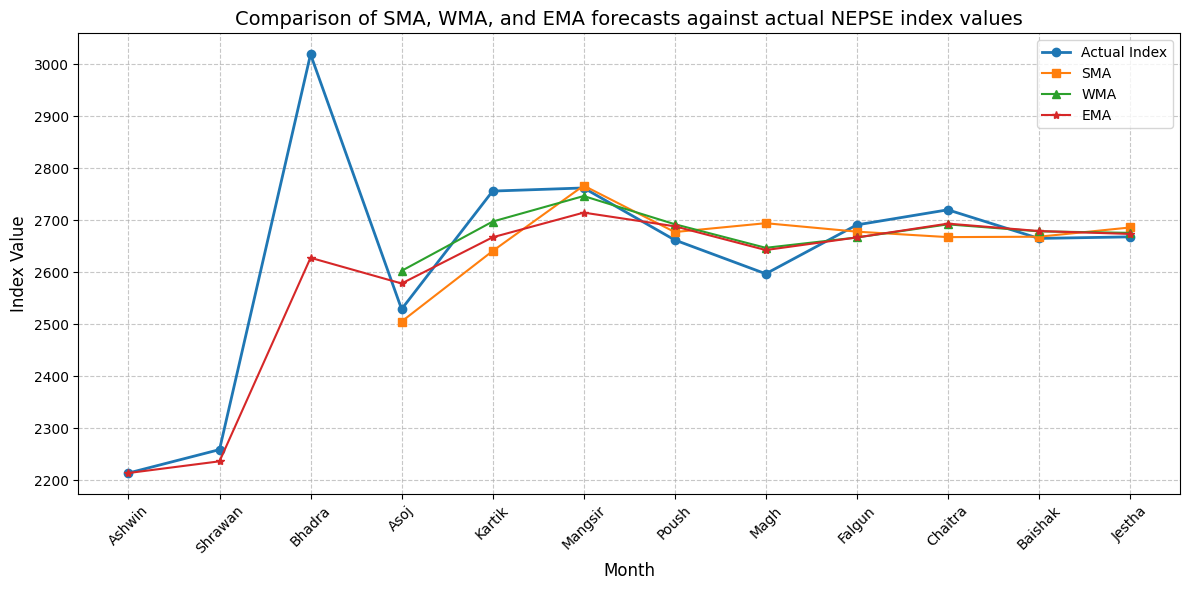

In [ ]:
# 5. Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Index'], marker='o', label='Actual Index', linewidth=2)
plt.plot(df['Month'], df['SMA'], marker='s', label='SMA', linewidth=1.5)
plt.plot(df['Month'], df['WMA'], marker='^', label='WMA', linewidth=1.5)
plt.plot(df['Month'], df['EMA'], marker='*', label='EMA', linewidth=1.5)

plt.title('Comparison of SMA, WMA, and EMA forecasts against actual NEPSE index values', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
# 6. Create a table for forecast accuracy analysis
accuracy_df = pd.DataFrame({
    'Month': df['Month'],
    'Index': df['Index'],
    'SMA': df['SMA'],
    'SMA_Error': df['SMA_Error'],
    'SMA_ErrorSq': df['SMA_ErrorSq'],
    'WMA': df['WMA'],
    'WMA_Error': df['WMA_Error'],
    'WMA_ErrorSq': df['WMA_ErrorSq'],
    'EMA': df['EMA'],
    'EMA_Error': df['EMA_Error'],
    'EMA_ErrorSq': df['EMA_ErrorSq']
})

print("\nForecast Accuracy Analysis:")
print(accuracy_df.to_string())


Forecast Accuracy Analysis:
      Month  Index      SMA  SMA_Error  SMA_ErrorSq          WMA  WMA_Error  WMA_ErrorSq          EMA   EMA_Error    EMA_ErrorSq
0    Ashwin   2214      NaN        NaN          NaN          NaN        NaN          NaN  2214.000000    0.000000       0.000000
1   Shrawan   2259      NaN        NaN          NaN          NaN        NaN          NaN  2236.500000   22.500000     506.250000
2    Bhadra   3019      NaN        NaN          NaN          NaN        NaN          NaN  2627.750000  391.250000  153076.562500
3      Asoj   2529  2505.25      23.75     564.0625  2602.666667 -73.666667  5426.777778  2578.375000  -49.375000    2437.890625
4    Kartik   2756  2640.75     115.25   13282.5625  2697.400000  58.600000  3433.960000  2667.187500   88.812500    7887.660156
5   Mangsir   2762  2766.50      -4.50      20.2500  2746.466667  15.533333   241.284444  2714.593750   47.406250    2247.352539
6     Poush   2662  2677.25     -15.25     232.5625  2692.333333 -30

In [ ]:
# 7. Calculate total error sum and MSE as in the document
sma_total_error = df['SMA_ErrorSq'].sum()
wma_total_error = df['WMA_ErrorSq'].sum()
ema_total_error = df['EMA_ErrorSq'].sum()

sma_mse_doc = sma_total_error / 7  # Divisor based on non-NaN values
wma_mse_doc = wma_total_error / 7
ema_mse_doc = ema_total_error / 11  # EMA has values for all but the first point

print("\nTotal Error Sum and MSE (as calculated in the document):")
print(f"SMA Total Error: {sma_total_error:.2f}, MSE: {sma_mse_doc:.2f}")
print(f"WMA Total Error: {wma_total_error:.2f}, MSE: {wma_mse_doc:.2f}")
print(f"EMA Total Error: {ema_total_error:.2f}, MSE: {ema_mse_doc:.2f}")

# Save figure
plt.savefig('moving_averages_comparison.png')
plt.show()


Total Error Sum and MSE (as calculated in the document):
SMA Total Error: 26816.81, MSE: 3830.97
WMA Total Error: 14128.85, MSE: 2018.41
EMA Total Error: 170455.61, MSE: 15495.96


<Figure size 640x480 with 0 Axes>